In [11]:
from functools import partial
from typing import *
import os

import numpy as np
import torch
from torch import Tensor
import transformers
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts

import llminference as L
from transformers.models.llama.modeling_llama import LlamaForCausalLM
from transformers.models.llama.modeling_llama import LlamaAttention

torch.set_num_threads(32)

sns.set_context("paper", font_scale=1.5)
matplotlib.rc('font', **{'family': 'serif', 'serif': ["CMU Serif"]})
matplotlib.rc('text', usetex=True)
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)

'/nethome/ivanc/llms/llmenv/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

## Pythia setup

In [12]:
adapter = L.Adapter.from_pretrained("EleutherAI/pythia-1.4b")
data = L.tasks.qa.SQuAD.data()
pythia_samples = 100
examples = [L.tasks.qa.add_few_shot_prompt(data[i], k=1, prompt_template=L.tasks.qa.get_default_prompt_template(adapter.model.config._name_or_path, shots=1))
    for i in range(pythia_samples)]

In [ ]:
tensor_paths = ["/net/group/research/ivanc/sparq_paper/Q_pythia_1p4b", 
                "/net/group/research/ivanc/sparq_paper/K_pythia_1p4b", 
                "/net/group/research/ivanc/sparq_paper/M_pythia_1p4b"]
MODEL_NAME = "Pythia"
if all([os.path.exists(p) for p in tensor_paths]):
    print("Loading tensors from file.")
    Q = torch.load("/net/group/research/ivanc/sparq_paper/Q_pythia_1p4b")
    K = torch.load("/net/group/research/ivanc/sparq_paper/K_pythia_1p4b")
    M = torch.load("/net/group/research/ivanc/sparq_paper/M_pythia_1p4b")
    print("Tensors loaded.")
else:
    print("Creating and saving tensors.")
    log_q = {}
    log_k = {}
    log_m = {}
    def logging_attn(layer_idx, self, query, key, value, attention_mask=None, head_mask=None):
        q = torch.nn.functional.pad(query, [0, 0, 2048 - query.shape[2], 0, 0, 0, 0, 0])
        k = torch.nn.functional.pad(key, [0, 0, 2048 - key.shape[2], 0, 0, 0, 0, 0])
        m = torch.nn.functional.pad(attention_mask, [2048 - key.shape[2], 0, 0, 0, 0, 0], value=-1e9)

        log_q[layer_idx] = torch.concat([log_q[layer_idx], q], axis=0) if layer_idx in log_q else q
        log_k[layer_idx] = torch.concat([log_k[layer_idx], k], axis=0) if layer_idx in log_k else k
        log_m[layer_idx] = torch.concat([log_m[layer_idx], m], axis=0) if layer_idx in log_m else m
        return transformers.models.gpt_neox.modeling_gpt_neox.GPTNeoXAttention._attn(
            self, query, key, value, attention_mask=attention_mask, head_mask=head_mask)
        
    for layer_idx, layer in enumerate(adapter.model.gpt_neox.layers):
        layer.attention._attn = partial(logging_attn, layer_idx, layer.attention)

    out = list(L.tasks.qa.evaluate(adapter, examples[:pythia_samples], batch_size=1, output_token_limit=1))
    
    Q = torch.stack(list(log_q.values())).swapaxes(0, 1)[..., -1:, :]
    K = torch.stack(list(log_k.values())).swapaxes(0, 1)
    M = torch.stack(list(log_m.values())).swapaxes(0, 1)

    print(M.shape)

    torch.save(Q, "/net/group/research/ivanc/sparq_paper/Q_pythia_1p4b")
    torch.save(K, "/net/group/research/ivanc/sparq_paper/K_pythia_1p4b")
    torch.save(M, "/net/group/research/ivanc/sparq_paper/M_pythia_1p4b")

def attention_weight(q: Tensor, k: Tensor, mask: Tensor) -> Tensor:
    a = (q @ k.transpose(-1, -2)).mul_(q.shape[-1]**-0.5).add_(mask)
    return torch.nn.functional.softmax(a, dim=-1)
A = attention_weight(Q, K, M).squeeze(-2)
A.shape

Loading tensors from file.


## LLama set-up 

In [101]:
adapter_llama = L.Adapter.from_pretrained("meta-llama/Llama-2-7b-hf")

def convert(model: LlamaForCausalLM) -> LlamaForCausalLM:
    def _replace(m: torch.nn.Module) -> Optional[torch.nn.Module]:
        if isinstance(m, LlamaAttention):
            return L.models.llama_attention.LlamaAttention(model.config)

    return L.utility.convert_module(model, _replace)

adapter_llama.model = convert(adapter_llama.model)
data = L.tasks.qa.SQuAD.data()
examples = [L.tasks.qa.add_few_shot_prompt(data[i], k=1, prompt_template=L.tasks.qa.get_default_prompt_template(adapter_llama.model.config._name_or_path, shots=1))
    for i in range(50)]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
tensor_paths = ["/nethome/ivanc/sparq_paper/Q_llama2_7b", 
                "/nethome/ivanc/sparq_paper/K_llama2_7b", 
                "/nethome/ivanc/sparq_paper/M_llama2_7b"]
MODEL_NAME = "Llama 2"
if all([os.path.exists(p) for p in tensor_paths]):
    Q = torch.load("/nethome/ivanc/sparq_paper/Q_llama2_7b")
    K = torch.load("/nethome/ivanc/sparq_paper/K_llama2_7b")
    M = torch.load("/nethome/ivanc/sparq_paper/M_llama2_7b")
else:
    log_q = {}
    log_k = {}
    log_m = {}
    def logging_attn(layer_idx, self, query, key, value, attention_mask=None):
        q = torch.nn.functional.pad(query, [0, 0, 2048 - query.shape[2], 0, 0, 0, 0, 0])
        k = torch.nn.functional.pad(key, [0, 0, 2048 - key.shape[2], 0, 0, 0, 0, 0])
        # m = torch.nn.functional.pad(attention_mask, [2048 - key.shape[2], 0, 0, 0, 0, 0], value=-1e9)
        
        log_q[layer_idx] = torch.concat([log_q[layer_idx], q], axis=0) if layer_idx in log_q else q
        log_k[layer_idx] = torch.concat([log_k[layer_idx], k], axis=0) if layer_idx in log_k else k
        # log_m[layer_idx] = torch.concat([log_m[layer_idx], m], axis=0) if layer_idx in log_m else m
        return L.models.llama_attention.LlamaAttention._attn(self, query, key, value, attention_mask=attention_mask)
    
    for layer_idx, layer in enumerate(adapter_llama.model.model.layers):
        layer.self_attn._attn = partial(logging_attn, layer_idx, layer.self_attn)
    out = list(L.tasks.qa.evaluate(adapter_llama, examples[:50], batch_size=1, output_token_limit=1))
    
    Q = torch.stack(list(log_q.values())).swapaxes(0, 1)[..., -1:, :]
    K = torch.stack(list(log_k.values())).swapaxes(0, 1)
    M = torch.stack(list(log_m.values())).swapaxes(0, 1)
    torch.save(Q, "/nethome/ivanc/sparq_paper/Q_llama2_7b")
    torch.save(K, "/nethome/ivanc/sparq_paper/K_llama2_7b")
    torch.save(M, "/nethome/ivanc/sparq_paper/M_llama2_7b")

def attention_weight(q: Tensor, k: Tensor, mask: Tensor) -> Tensor:
    a = (q @ k.transpose(-1, -2)).mul_(q.shape[-1]**-0.5).add_(mask)
    return torch.nn.functional.softmax(a, dim=-1)
A = attention_weight(Q, K, M).squeeze(-2)
A.shape

tensor([1039., 1792.])

# 1. The output of softmax is dominated by a small number of elements

In [4]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

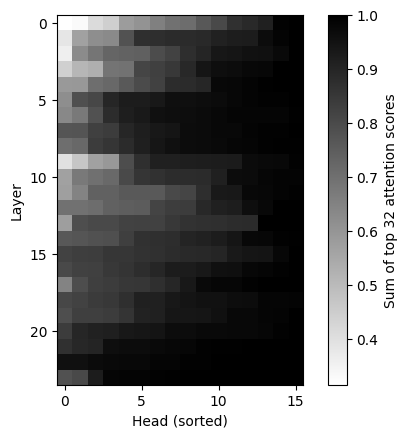

In [5]:
k = 32
topk_metric = torch.topk(A, k=k, dim=-1).values.sum(-1)
ax = plt.gca()
img = ax.imshow(torch.sort(topk_metric.mean(0), dim=1).values, cmap="gray_r", vmax=1)
plt.colorbar(img, ax=ax, label=f"Sum of top {k} attention scores")
ax.set_xlabel("Head (sorted)")
ax.set_ylabel("Layer")
plt.show();

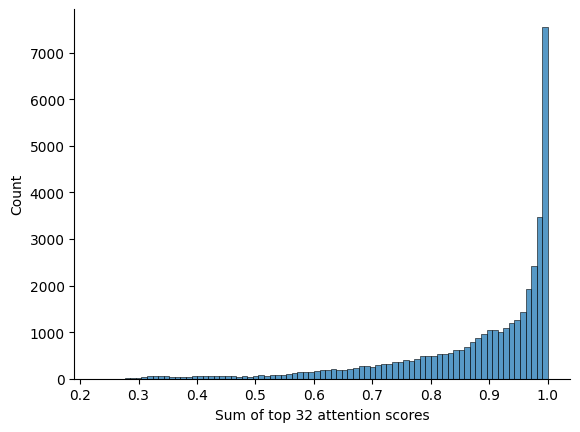

In [6]:
ax = sns.histplot(topk_metric.flatten())
sns.despine(ax=ax)
ax.set_xlabel(f"Sum of top {k} attention scores")
plt.show();

# 2. The indices of the largest attention scores can be predicted without fetching the full $K$ matrix, using the top-magnitude components of $q$

In [7]:
def approx_score(q: Tensor, k: Tensor, mask: Tensor, rank: int, method: str) -> Tensor:
    if method == "top":
        i = torch.topk(q.abs(), k=rank, dim=-1).indices
    elif method == "first":
        i = torch.arange(rank).expand(*q.shape[:-1], rank)
    ik = i.expand(*k[..., :rank].shape)
    return (torch.gather(q, -1, i) @ torch.gather(k, -1, ik).transpose(-1, -2)) + mask

def topk_agreement(a: Tensor, b: Tensor, mask: Tensor, k: int) -> Tensor:
    ma = (a >= -torch.kthvalue(-a, k=k, keepdim=True).values)
    mb = (b >= -torch.kthvalue(-b, k=k, keepdim=True).values)
    m = mask == 0
    return (ma & mb & m).sum(-1) / torch.minimum(m.sum(-1), torch.tensor(k))

rank = 16
k = 32
agreement_top = topk_agreement(A, approx_score(Q[..., -1:, :], K, M, rank=rank, method="top").squeeze(-2), M.squeeze(-2), k=k)
agreement_first = topk_agreement(A, approx_score(Q[..., -1:, :], K, M, rank=rank, method="first").squeeze(-2), M.squeeze(-2), k=k)

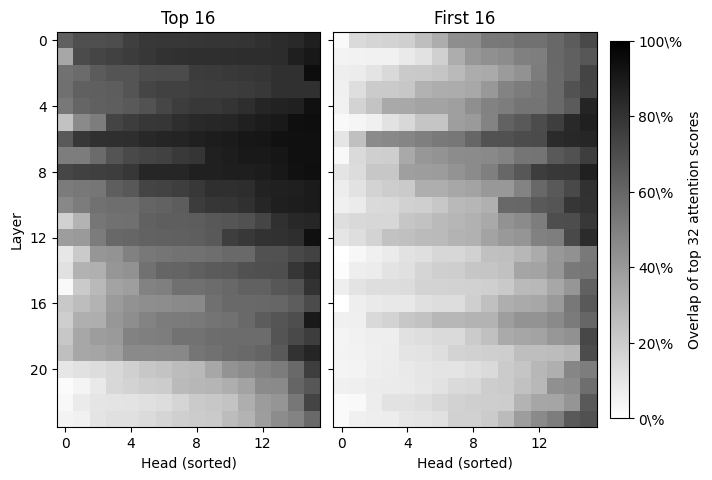

In [8]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 5), sharey=True, layout="constrained")
img = ax0.imshow(torch.sort(agreement_top.mean(0), dim=1).values, cmap="gray_r", vmin=0, vmax=1)
ax1.imshow(torch.sort(agreement_first.mean(0), dim=1).values, cmap="gray_r", vmin=0, vmax=1)
fig.colorbar(img, ax=ax1, shrink=.82, label=f"Overlap of top {k} attention scores", format=lambda x, _: f"{x*100:.0f}\%")
ax0.set_ylabel("Layer")
for ax in [ax0, ax1]:
    ax.set_xlabel("Head (sorted)")
    ax.set_xticks([0, 4, 8, 12])
    ax.set_yticks(list(range(0, 24, 4)))
ax0.set_title(f"Top {rank}")
ax1.set_title(f"First {rank}")
plt.show()

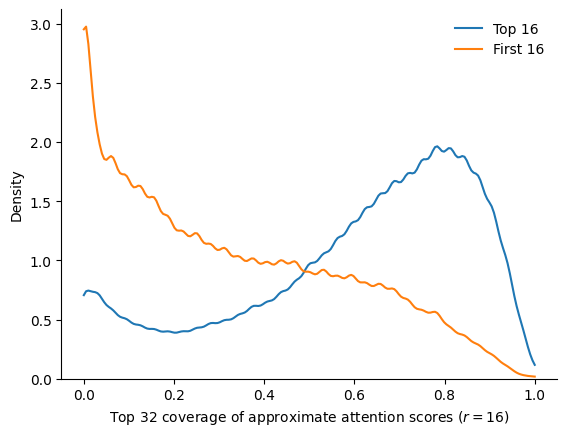

In [9]:
ax = plt.gca()
sns.kdeplot(agreement_top.flatten(), clip=(0, 1), bw_adjust=.5, label=f"Top {rank}", ax=ax)
sns.kdeplot(agreement_first.flatten(), clip=(0, 1), bw_adjust=.5, label=f"First {rank}", ax=ax)
sns.despine(ax=ax)
ax.legend(frameon=False)
ax.set_xlabel(f"Top {k} coverage of approximate attention scores ($r={rank})$")
plt.show()

In [ ]:
agreement_tensors = {}
for i, rank in enumerate([64, 32, 16,8]):
    k_range = [2**k for k in range(10)]
    scores_func = lambda x: topk_agreement(A, approx_score(Q[..., -1:, :], K, M, rank=rank, method="top").squeeze(-2), M.squeeze(-2), k=x)
    agreement_tensors[rank] = [scores_func(k) for k in k_range]

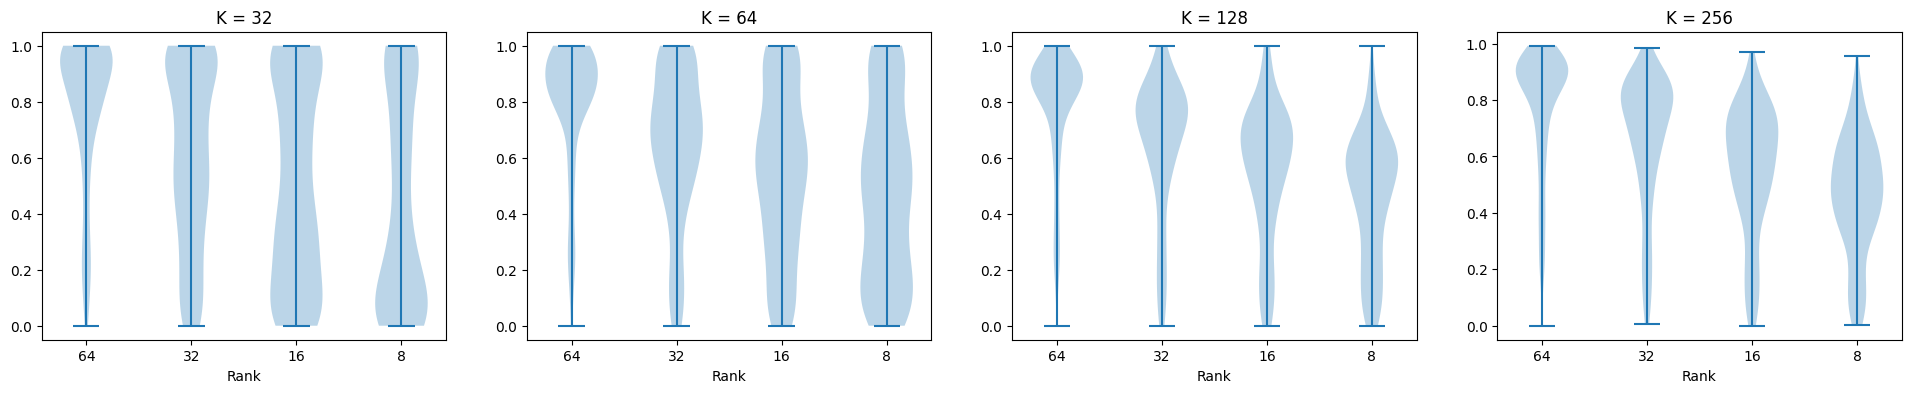

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=len(k_range[5:-1]), figsize=(24, 4))
for i, k in enumerate(k_range[5:-1]):
    axs[i].violinplot([v[i].mean(0).flatten() for v in agreement_tensors.values()])
    axs[i].set_title(f"K = {k}")
    axs[i].set_xticks([y + 1 for y in range(4)],
                  labels=['64', '32', '16', '8'])
    axs[i].set_xlabel('Rank')
    
plt.show()

# 3. KDE of $q$ vectors

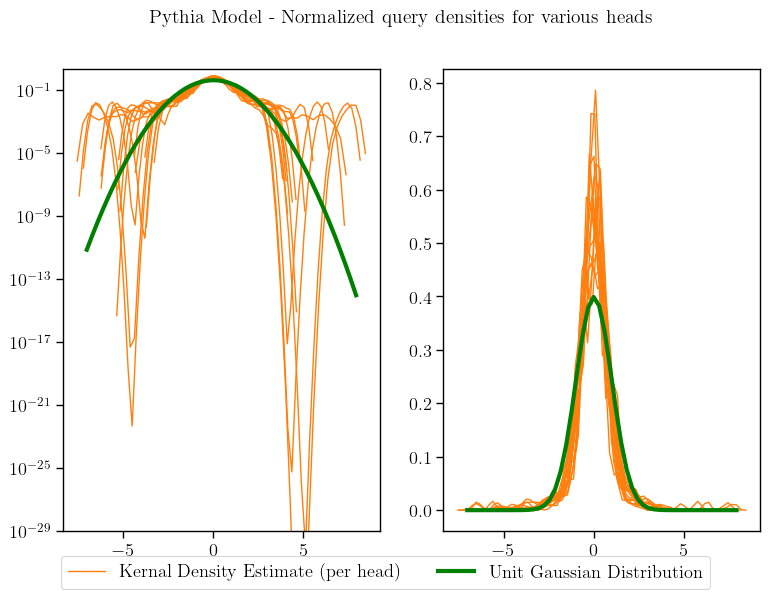

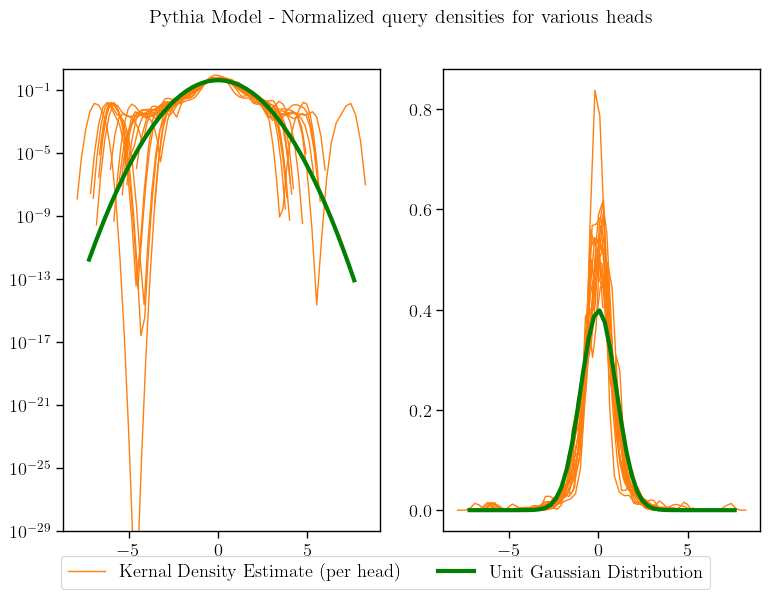

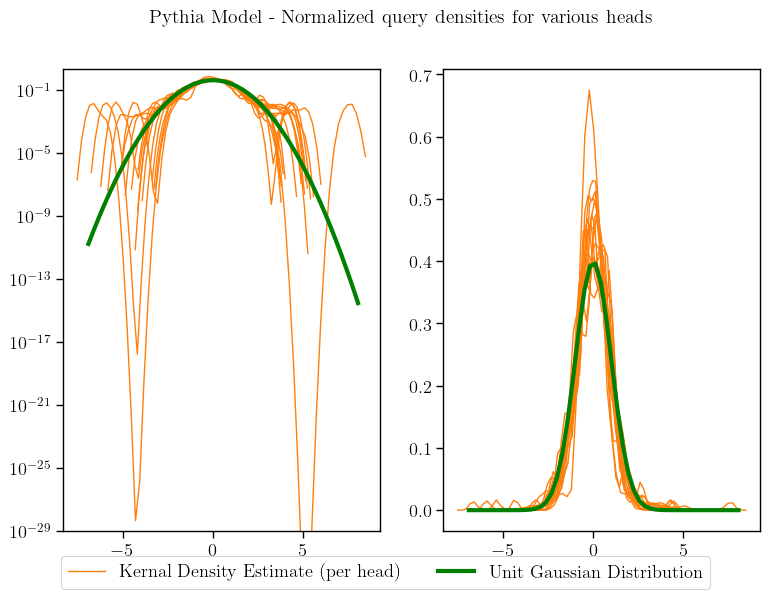

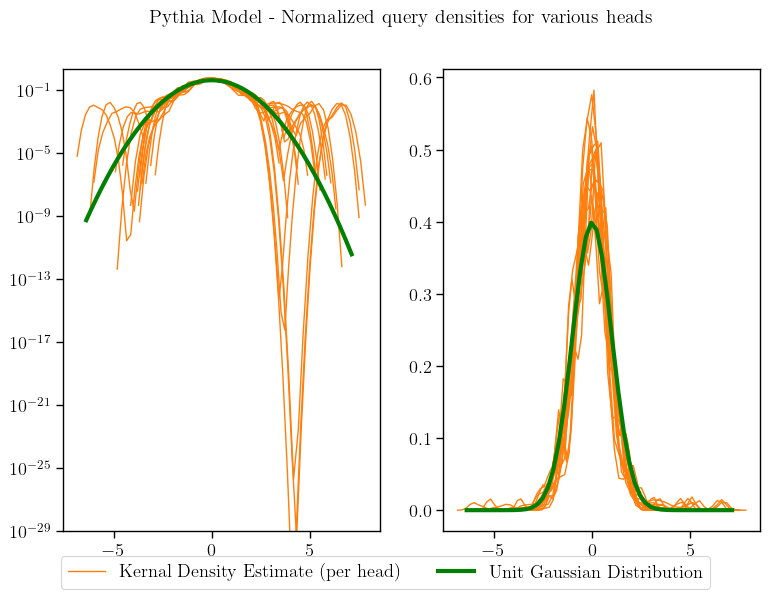

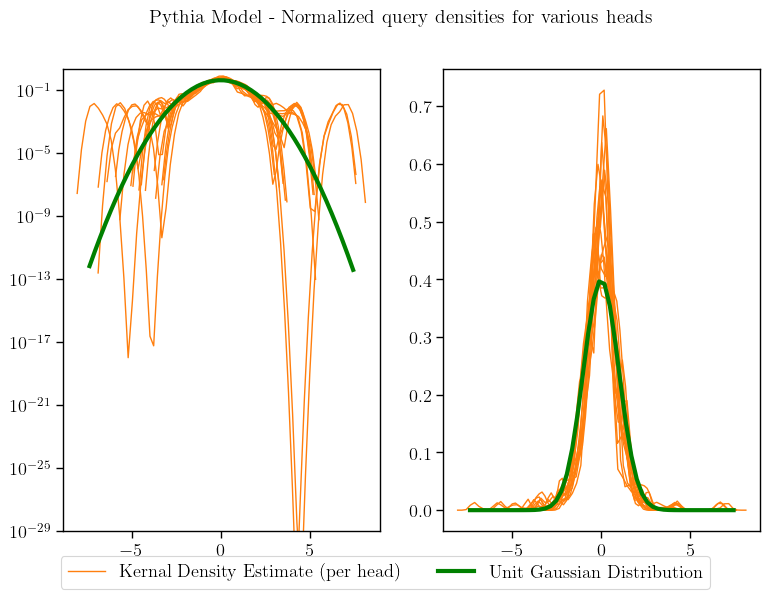

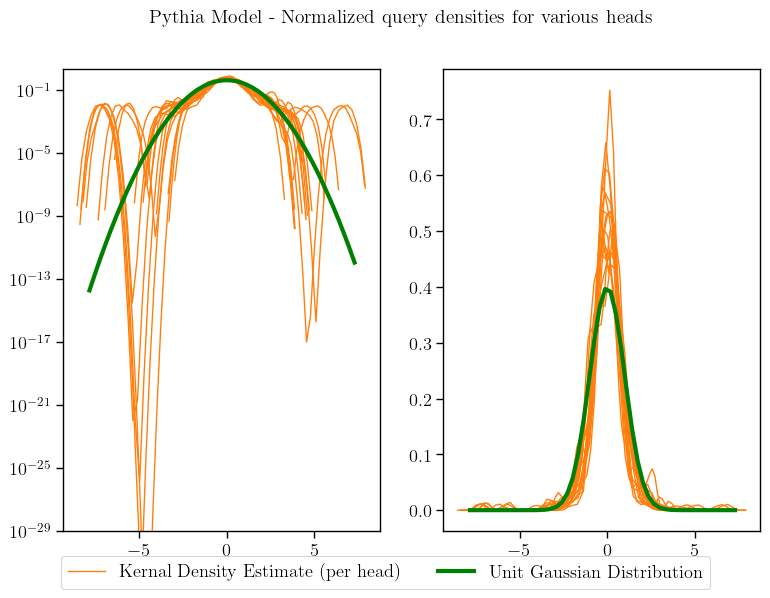

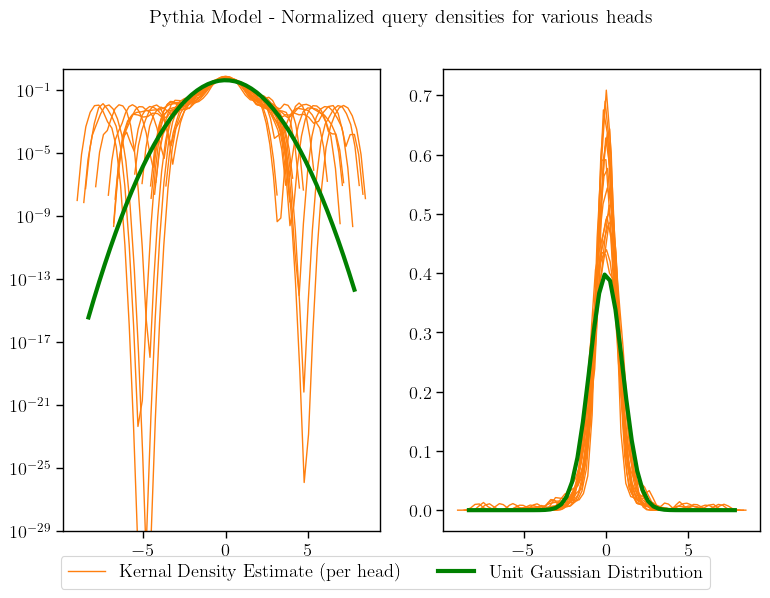

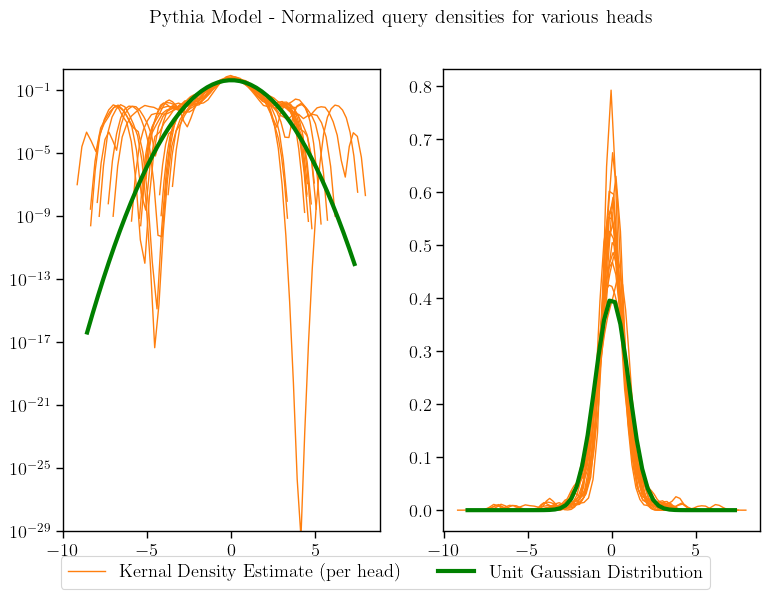

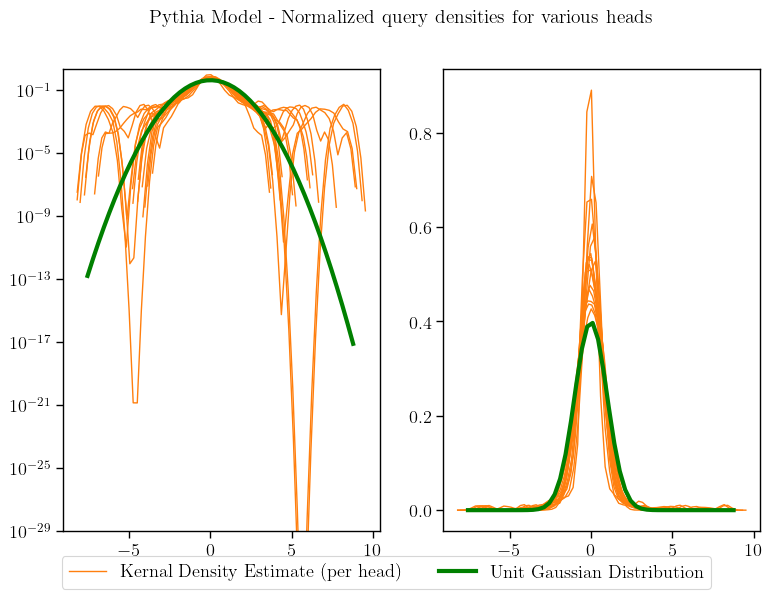

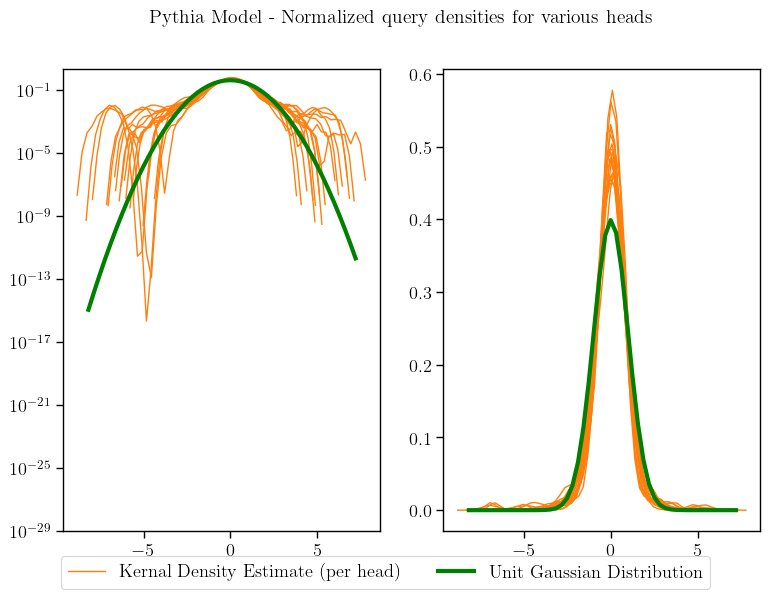

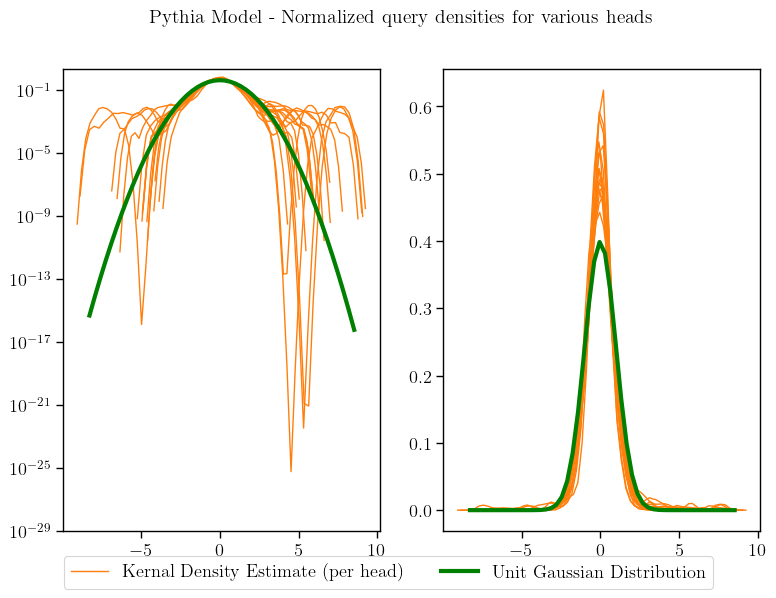

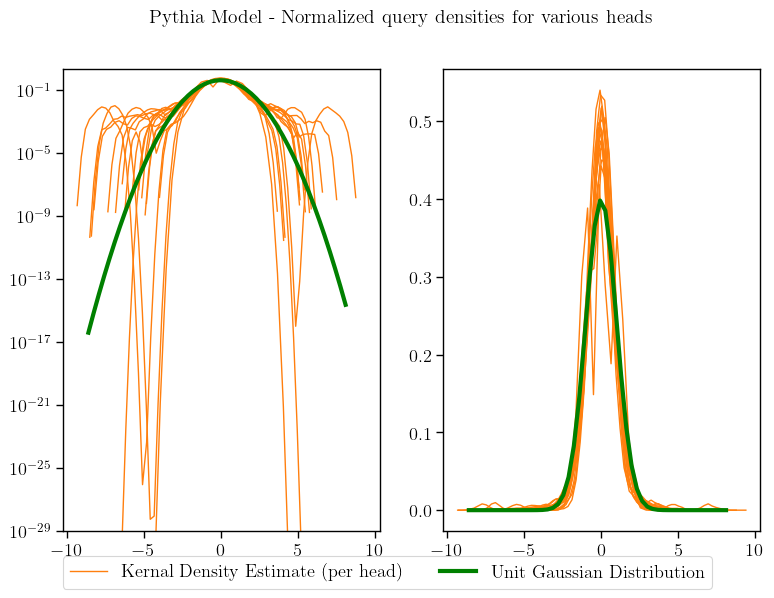

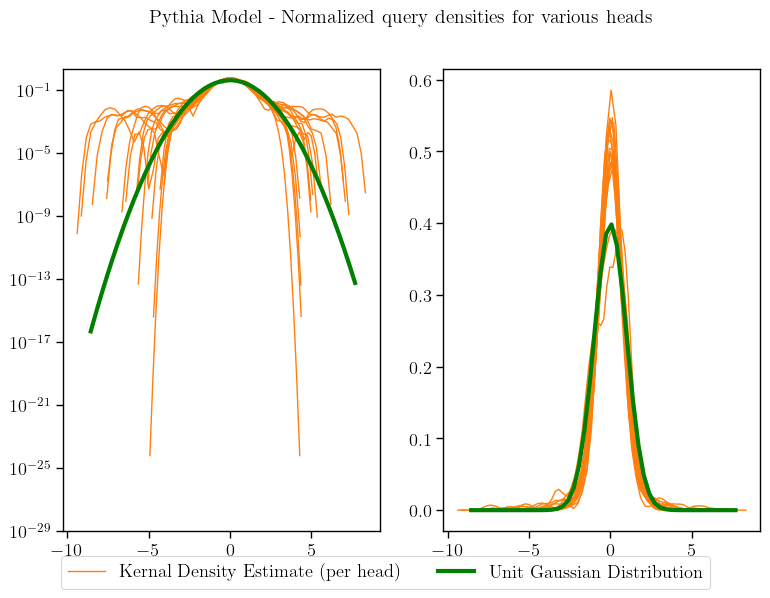

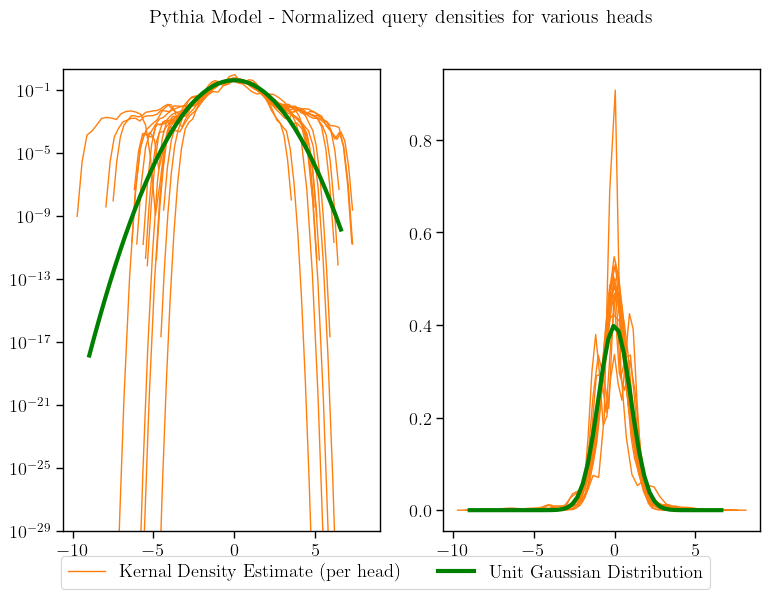

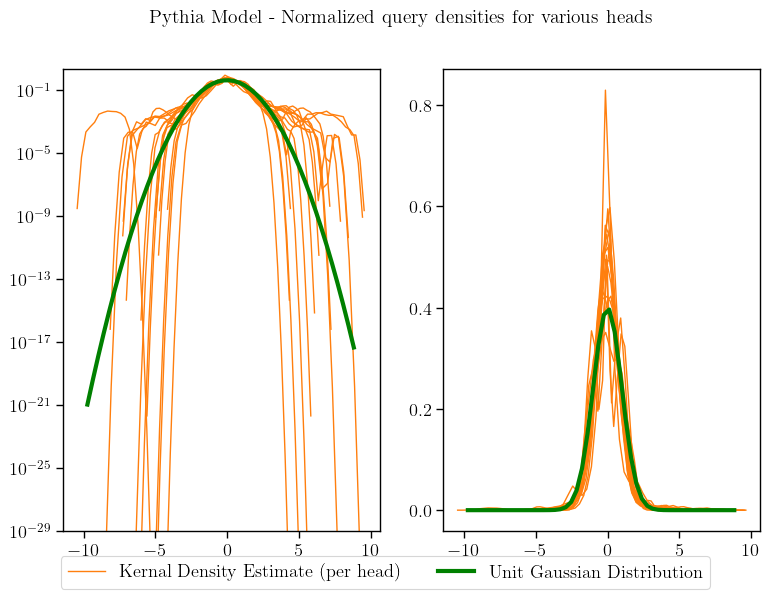

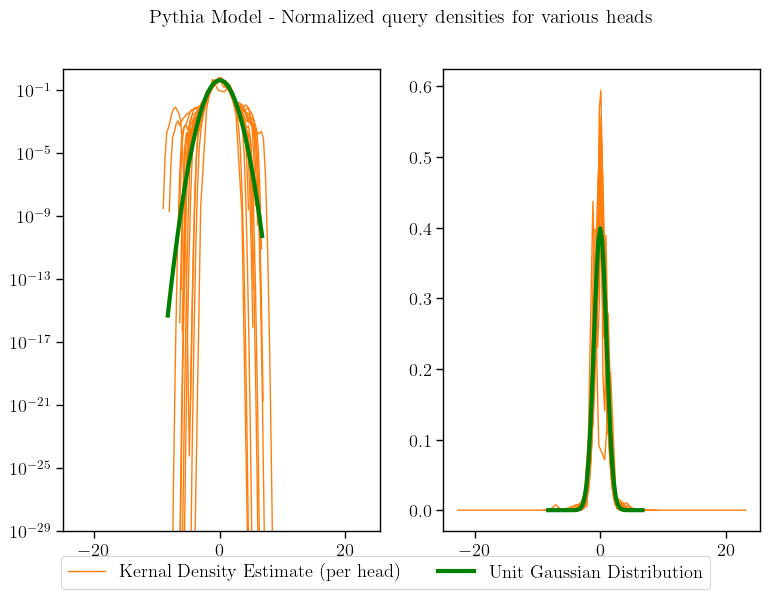

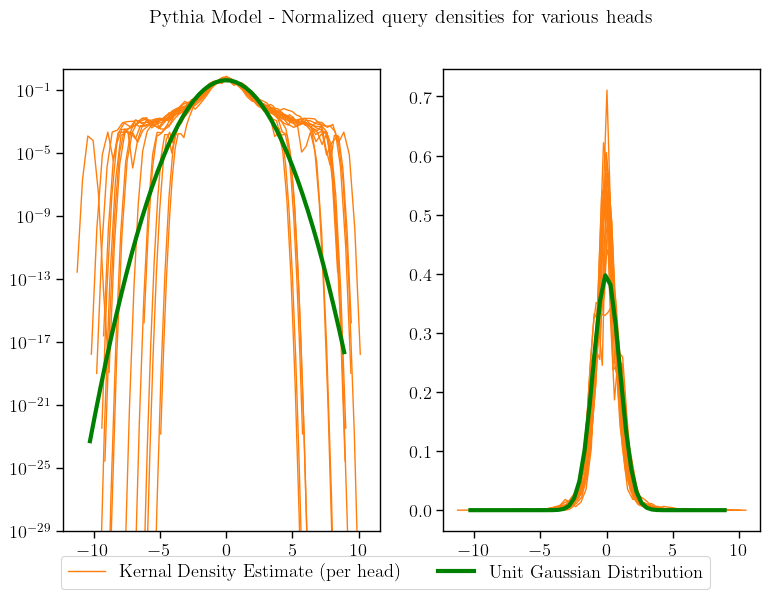

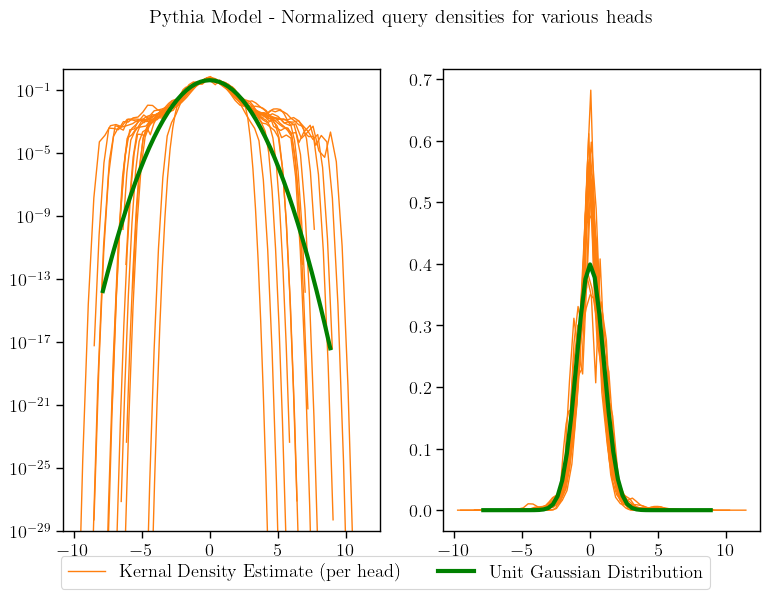

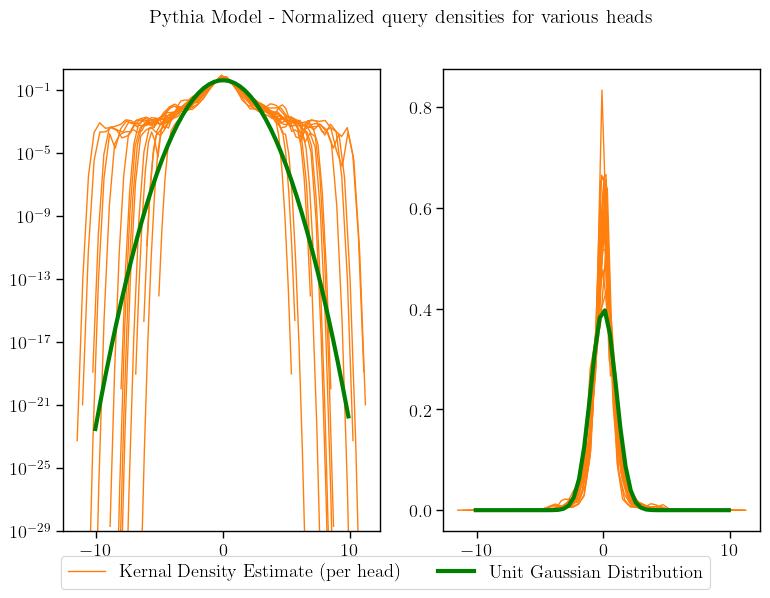

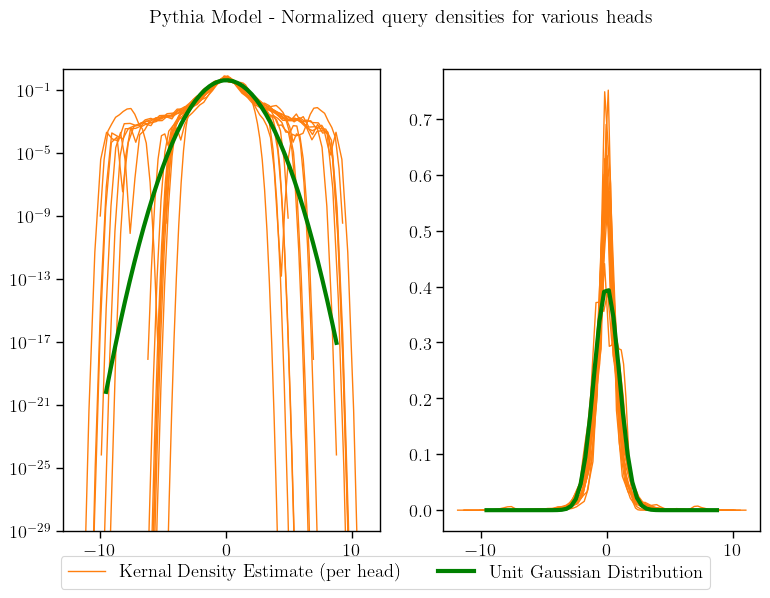

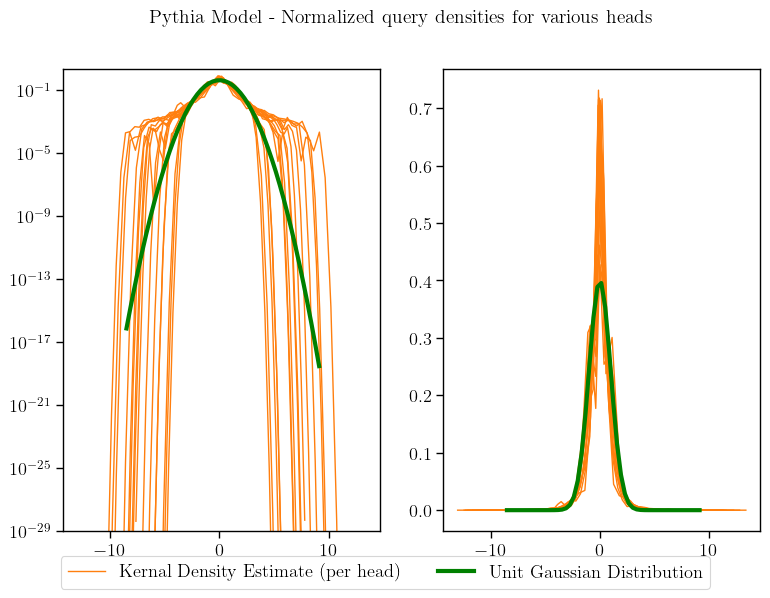

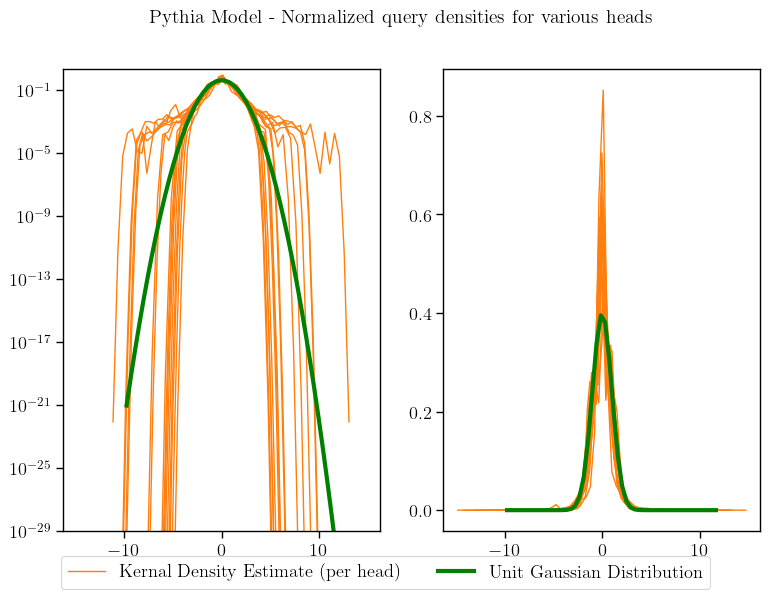

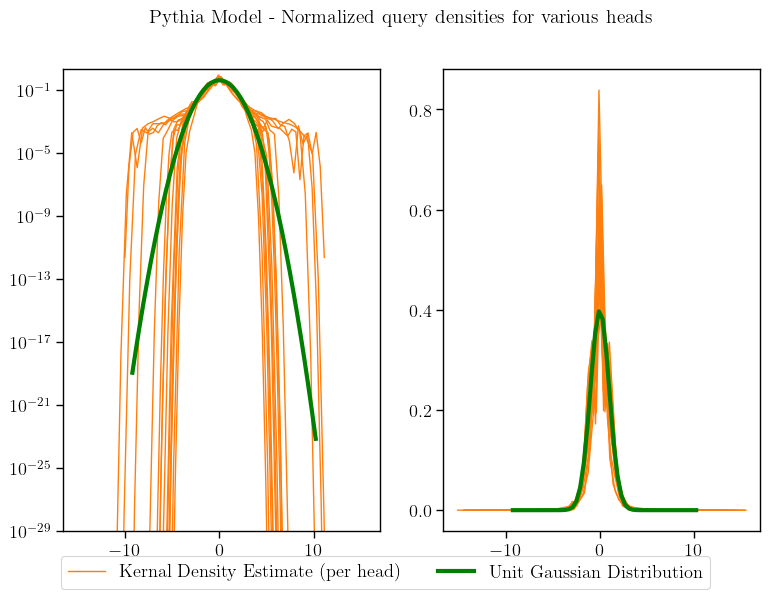

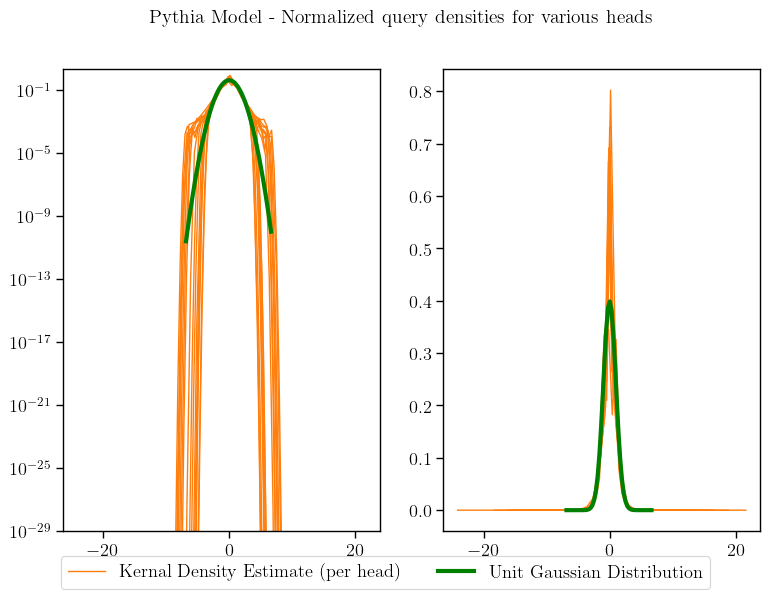

In [6]:
zscores = []
kurtosis = []
outer_mass = []

for j in range(Q.shape[1]):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 6), sharex=True)
    min_z, max_z = [], []
    for i in range(Q.shape[2]):
        e = torch.flatten(Q[:,j,i,0])
        mean, var = e.mean(), e.var()
        zvec = (e - mean) / np.sqrt(var)
        mask = zvec.abs() > 3.0
        end_mask = torch.masked_fill(torch.zeros(e.shape), mask, 1.0)
        min_z.append(zvec.min())
        max_z.append(zvec.max()) 
        x = np.linspace(zvec.min()-0.5*np.sqrt(var), zvec.max()+0.5*np.sqrt(var))
        kde = sts.gaussian_kde(zvec, bw_method="scott") 

        label = "Kernal Density Estimate (per head)" if not i else None
        axs[0].plot(x, kde.pdf(x), c='C1', lw=1)
        
        outer_mass.append((end_mask * e).abs().sum() / e.abs().sum())
        zscores.append(zvec.abs().max())
        kurtosis.append(sts.kurtosis(e, fisher=True, bias=True))
        
        axs[1].plot(x, kde.pdf(x), c='C1', lw=1, label=label)

        axs[0].set_yscale("log")
        axs[0].set_ylim(bottom=10e-30, top=2)
    x_full = np.linspace(min(min_z), max(max_z))
    axs[0].plot(x_full, sts.norm.pdf(x_full, 0, 1), lw=3, c="green")
    axs[1].plot(x_full, sts.norm.pdf(x_full, 0, 1), lw=3, c="green", label = "Unit Gaussian Distribution")

    # fig.tight_layout()
    fig.suptitle(f'{MODEL_NAME} Model - Normalized query densities for various heads', fontsize=14)
    fig.legend(fancybox=True, loc="lower center",  ncol=2)
    plt.show()

Text(0.5, 1.0, '|z| > 3.0 q-vector mass')

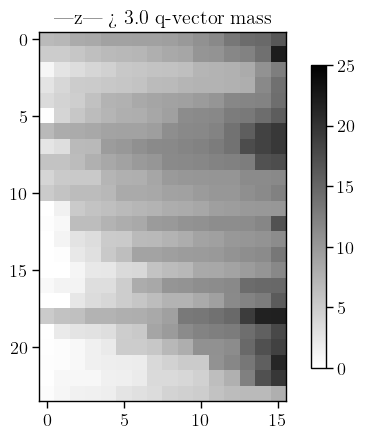

In [7]:
img = plt.imshow(torch.sort(torch.Tensor(outer_mass).view(Q.shape[1],Q.shape[2])).values, cmap="gray_r", vmin=0, vmax=0.25)
plt.colorbar(img, shrink=.82, format=lambda x, _: f"{x*100:.0f}%")
plt.title("|z| > 3.0 q-vector mass")

Text(0.5, 1.0, '|z| > 3.0 q-vector mass vs normal distribution (Llama)')

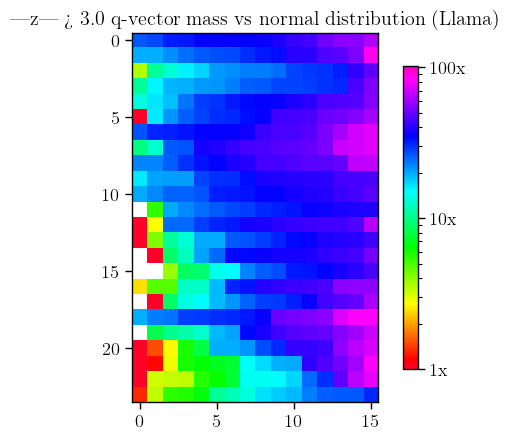

In [8]:
from matplotlib.colors import LogNorm
img = plt.imshow(torch.sort(torch.Tensor(outer_mass).view(Q.shape[1],Q.shape[2])).values/0.0026, cmap="gist_rainbow", norm=LogNorm(vmin=1, vmax=102))
plt.colorbar(img, shrink=.82, format=lambda x, _: f"{x:.0f}x")
plt.title("|z| > 3.0 q-vector mass vs normal distribution (Llama)")

Text(0.5, 1.0, 'Max z-value')

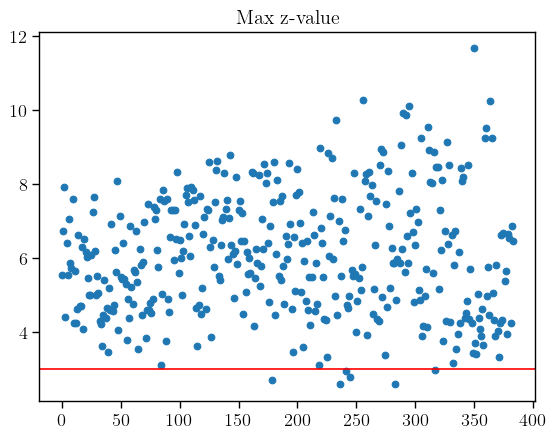

In [9]:
# plt.scatter(np.arange(len(zscores)), zscores)
# plt.axhline(y=3, color='r', linestyle='-')
# plt.title("Max z-value")

Text(0.5, 1.0, 'Kurtosis (Fisher)')

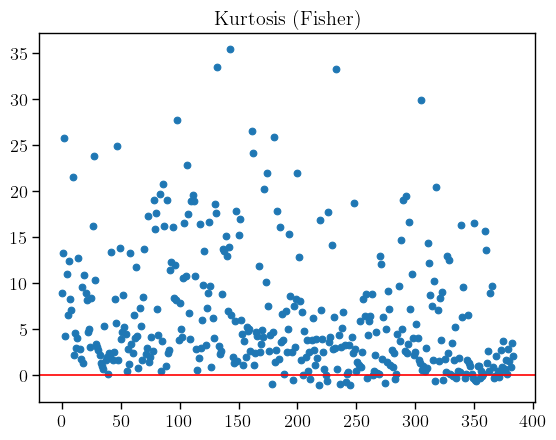

In [10]:
plt.scatter(np.arange(len(kurtosis)), kurtosis)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.title("Kurtosis (Fisher)")

In [ ]:
# for param in adapter.model.named_parameters():
#    if "weight" in param[0]:
#        param[1].data.normal_(mean=0.0, std=0.02)
#    elif 'bias' in param[0]:
#        param[1].data.zero_()